# CNN practice

1. simple CNN
2. deep CNN
3. ?
4. ?
5. ensemble
6. low memory

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

from mnist import MNIST

2023-07-03 15:07:48.825662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 15:07:48.941310: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 15:07:49.597818: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.7/lib64:/usr/local/cuda/extras/CUPTI/:/usr/local/cuda-11.7/lib64:/u

# Load Image

In [2]:
mndata = MNIST('../data/mnist/')

train_images, train_labels = mndata.load_training()
test_images, test_labels = mndata.load_testing()

train_images = np.array(train_images).reshape((-1, 28, 28, 1))
train_labels = np.array(train_labels)
test_images = np.array(test_images).reshape((-1, 28, 28, 1))
test_labels = np.array(test_labels)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28, 1), (60000,), (10000, 28, 28, 1), (10000,))

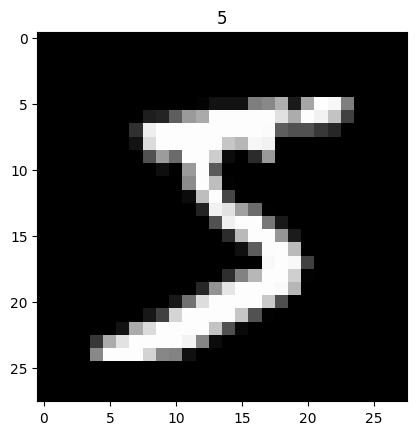

In [3]:
idx = 0

plt.title(train_labels[0])
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [4]:
train_labels_1hot = tf.one_hot(train_labels, 10)
test_labels_1hot = tf.one_hot(test_labels, 10)

train_labels_1hot.shape, test_labels_1hot.shape

2023-07-03 15:07:55.318002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 15:07:55.318274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 15:07:55.351389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 15:07:55.351642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 15:07:55.351811: I tensorflow/compiler/xla/stream_executo

(TensorShape([60000, 10]), TensorShape([10000, 10]))

# batches

In [5]:
batch_size = 100

train_batch_images = np.array([train_images[idx: idx+100] for idx in range(train_images.shape[0]//batch_size)])
train_batch_labels = np.array([train_labels_1hot[idx: idx+100] for idx in range(train_images.shape[0]//batch_size)])
test_batch_images = np.array([test_images[idx: idx+100] for idx in range(test_images.shape[0]//batch_size)])
test_batch_labels = np.array([test_labels_1hot[idx: idx+100] for idx in range(test_images.shape[0]//batch_size)])


train_batch_images.shape, train_batch_labels.shape, test_batch_images.shape, test_batch_labels.shape

((600, 100, 28, 28, 1), (600, 100, 10), (100, 100, 28, 28, 1), (100, 100, 10))

# Simple CNN

5 layers (last FC-10)

In [6]:
def conv_block(x, filter_nums, dropout_rate, name, weights=None):
    if isinstance(weights, np.ndarray):
        filters = weights
    else:
        filters = tf.Variable(tf.random.normal([3, 3, 1, filter_nums]))
    conv_output = tf.nn.conv2d(x, filters, (1,1,1,1), 'SAME', name=name)
    relu_output = tf.nn.relu(conv_output)
    pool_output = tf.nn.max_pool2d(
        relu_output, ksize=(1,2,2,1), strides=(1,2,2,1), padding='SAME')
    block_output = tf.nn.dropout(pool_output, rate=dropout_rate)
    return block_output

def fc_layer(x, units, weights=None):
    if not isinstance(weights, np.ndarray):
        weights = tf.Variable(tf.random.normal((x.shape[-1], units)))
    fc_output = tf.nn.relu(tf.matmul(x, weights))#+b)
    return fc_output

def last_layer(x, classes, weights=None):
    if not isinstance(weights, np.ndarray):
        weights = tf.Variable(tf.random.normal((x.shape[-1], classes)))
    logits = tf.matmul(x, weights)
    return logits

weights = [
    tf.Variable(tf.random.normal([3, 3, 1, 32])),
    tf.Variable(tf.random.normal([3, 3, 32, 64])),
    tf.Variable(tf.random.normal([3, 3, 64, 128])),
    tf.Variable(tf.random.normal((2048, 4096))),
    tf.Variable(tf.random.normal((4096, 4096))),
    tf.Variable(tf.random.normal((16777216, 10))),
]
    

def model(x, dropout_rate):

    # convolution blocks
    l1_output = conv_block(x, 32, dropout_rate, 'conv1', weights=weights[0])
    print("l1 output shape: ", l1_output.shape)
    l2_output = conv_block(l1_output, 64, dropout_rate, 'conv2', weights=weights[1])
    print("l2 output shape: ", l2_output.shape)
    l3_output = conv_block(l2_output, 128, dropout_rate, 'conv3', weights=weights[2])
    print("l3 output shape: ", l3_output.shape)

    # fc layers
    flatten = tf.reshape(l3_output, (x.shape[0], -1))
    print("flatten output shape: ", flatten.shape)
    l4_output = fc_layer(flatten, 4096, weights=weights[3])
    print("l4 output shape: ", l4_output.shape)
    l5_output = fc_layer(l4_output, 4096, weights=weights[4])
    print("l5 output shape: ", l5_output.shape)
    l6_output = last_layer(l5_output, 10, weights=weights[5])
    print("l6 output shape: ", l6_output.shape)

    return l6_output

In [8]:
model(test_images, 0.01)

2023-07-03 15:08:05.909893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500


l1 output shape:  (10000, 14, 14, 32)
l2 output shape:  (10000, 7, 7, 64)
l3 output shape:  (10000, 4, 4, 128)
flatten output shape:  (10000, 2048)
l4 output shape:  (10000, 4096)
l5 output shape:  (10000, 4096)
l6 output shape:  (10000, 10)


<tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[-1.63816064e+08,  9.59083200e+06, -1.13485680e+08, ...,
        -4.03661696e+08,  5.93513200e+07, -8.09990400e+07],
       [-1.23288288e+08, -2.46083408e+08, -3.19826240e+08, ...,
        -2.53948256e+08, -5.12824000e+05, -6.39689200e+06],
       [ 7.95191280e+07,  1.71299240e+07, -8.00841760e+07, ...,
        -2.55723584e+08,  1.23938984e+08, -1.39868440e+07],
       ...,
       [-3.42086400e+06, -4.60014400e+07, -2.21364960e+08, ...,
        -4.75228672e+08,  1.60268464e+08, -1.26697408e+08],
       [ 1.67859584e+08, -7.78992640e+07, -2.43200600e+06, ...,
        -3.46797280e+08,  1.56494480e+08, -1.08418304e+08],
       [-1.61473600e+07, -1.28449712e+08, -1.65830688e+08, ...,
        -5.39381056e+08,  5.27235600e+07, -1.73937312e+08]], dtype=float32)>

In [9]:
learning_rate = 0.0001
sgd = tf.keras.optimizers.SGD(learning_rate)

In [10]:
epochs = 5

for i in range(epochs):

    # for b, (batch_images, batch_labels) in enumerate(zip(train_batch_images, train_batch_labels)):
    with tf.GradientTape() as tape:
        # if len(weights):
        #     pred, _ = model(batch_images, 0.01, weights)
        pred = model(train_images, 0.01)
        # else:
        #     pred, weights = model(batch_images, 0.01)
        loss = tf.nn.softmax_cross_entropy_with_logits(train_labels_1hot, pred)
    sgd.minimize(loss, var_list=weights, tape=tape)
    print(f"epoch: {i}loss: {tf.reduce_sum(loss)}")
    # print(f"epoch: {i}, batches: {b}, loss: {tf.reduce_sum(loss)}")

2023-07-03 15:08:13.461564: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


l1 output shape:  (60000, 14, 14, 32)
l2 output shape:  (60000, 7, 7, 64)
l3 output shape:  (60000, 4, 4, 128)
flatten output shape:  (60000, 2048)
l4 output shape:  (60000, 4096)
l5 output shape:  (60000, 4096)
l6 output shape:  (60000, 10)


2023-07-03 15:08:25.355633: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-07-03 15:08:25.355851: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.90GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


ValueError: No gradients provided for any variable: (['Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0', 'Variable:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Variable:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[ 0.6466784 ,  1.3636801 ,  0.2349704 , -0.68872184,
           1.2708534 , -1.5039062 , -0.791255  , -0.93443525,
          -0.81759375,  1.4529178 , -0.93918484, -1.431791  ,
           0.19984002,  0.23216824, -2.6451733 , -1.4437139 ,
           0.92665076,  1.3199555 , -0.17193408, -0.8771541 ,
           0.250492  , -0.1008746 , -0.8012736 , -0.09100357,
           0.25474587,  0.5349384 , -0.04049704,  0.7610705 ,
          -2.3481848 ,  0.4639459 ,  0.67247576,  0.22725704]],

        [[ 0.07807124,  0.44073853,  1.9378729 , -0.52310944,
           1.4352068 , -0.53696984,  0.51148885, -0.36410838,
          -0.5732031 ,  1.829762  ,  0.14513761,  1.0515347 ,
          -0.68788207,  0.45367172, -1.7454324 ,  1.1318425 ,
          -0.4222951 , -0.3760836 ,  0.0555972 , -0.21359812,
          -1.0526816 ,  0.09952651, -1.172967  ,  0.08245756,
           0.27712423,  0.08589459, -0.7428122 ,  0.3805969 ,
           0.33666667,  0.83065766, -0.34107158,  0.34638366]],

        [[-1.5269016 , -0.0960945 ,  0.07590263, -0.54164255,
          -0.10711495, -1.380478  ,  1.0823843 ,  0.15391645,
          -0.924603  ,  0.18526798, -1.1310121 ,  0.2559383 ,
          -0.66276866,  0.68127084, -0.75414395, -0.07397736,
           0.5319093 , -0.71319413, -0.26535887,  0.2075439 ,
          -0.58865744, -0.9440555 , -0.88900894, -0.911177  ,
           0.65423936,  0.05467885, -0.9757518 , -1.5119768 ,
          -0.6218669 , -0.08284172, -0.51931447, -1.9477992 ]]],


       [[[ 0.09281781,  0.31672472, -0.15312561,  0.6576407 ,
          -0.06364119,  0.34230626,  0.09905884, -1.5473095 ,
          -2.164004  , -1.163612  , -0.6128797 , -0.92909676,
          -0.19283934,  1.3884772 , -0.33209106, -0.37142402,
          -0.8569481 ,  1.3128698 , -0.5343361 , -0.44202265,
          -0.28659397, -0.9150159 ,  1.0567747 ,  0.20239772,
           0.15196304,  1.8412681 ,  1.4837056 ,  0.0178719 ,
          -0.0156993 , -0.14400351,  1.2510555 ,  0.0341127 ]],

        [[-1.8503035 ,  1.8630394 , -0.8387479 , -0.99032676,
           0.88508016,  0.5592865 , -0.02534952,  0.11326825,
          -0.9367322 , -0.6940385 ,  1.6300179 ,  0.56942695,
          -0.1246592 , -0.2373819 ,  0.08806559, -0.35537207,
           0.26375145,  1.5500369 , -1.231266  ,  1.4507219 ,
           1.2303547 , -0.5123373 , -0.5643674 , -0.8016935 ,
          -0.32689306,  0.5819346 , -0.4012869 ,  0.6183318 ,
           0.5949261 , -0.49499986,  1.1726246 , -0.36204967]],

        [[-1.0130643 , -0.11574296,  0.2570927 ,  0.19586007,
           1.9387752 , -0.606752  , -2.0620928 , -0.58435684,
          -0.3675099 ,  0.671357  , -1.0613112 , -0.10118797,
          -1.6306659 , -1.4144033 ,  0.7392334 , -0.09799367,
          -0.06009875, -0.01182518,  1.5021986 ,  1.0187073 ,
           0.24639466, -0.6482466 , -0.09944835, -0.21933323,
          -0.95047796, -0.15839301, -0.5509325 ,  0.84376884,
          -1.1356637 ,  0.69268423,  0.31964287, -1.2675667 ]]],


       [[[-0.80905783,  0.8667199 , -0.25556275,  0.8523271 ,
          -0.48429334, -0.37295645, -0.64549637,  0.43377215,
           0.21906446, -1.2036375 ,  0.52927613, -1.050511  ,
           0.7938159 ,  0.11210593, -0.38645473, -0.41139477,
          -0.9570582 , -1.6779778 ,  0.695617  ,  0.31683645,
          -1.4159051 , -1.5264475 , -1.3047926 , -0.5657302 ,
           0.18516006,  0.97149384,  0.6025923 ,  1.5755728 ,
          -0.25813797,  0.44717535,  0.06383213, -0.2831915 ]],

        [[-1.7273619 ,  2.3258348 , -0.34049243,  0.37726212,
           0.57444376, -0.39842898,  0.8879237 ,  0.31475452,
          -1.8742999 , -1.6084414 ,  0.46315092, -1.3360512 ,
          -0.45779213, -0.3701041 ,  0.61123586, -1.5635326 ,
          -0.4760754 , -1.2992508 , -1.0136776 ,  0.9237997 ,
           0.67889476,  1.4121991 ,  0.15044291,  1.1735282 ,
          -0.12994803, -0.40697154,  0.0719725 , -0.19998203,
          -0.0301965 , -0.5427759 ,  1.5363353 ,  0.9429556 ]],

        [[-0.33671847,  1.3157446 ,  0.480834  , -1.2014211 ,
          -1.0534788 ,  0.27704492,  0.7215707 ,  0.938482  ,
          -0.04459808, -0.16646737, -0.31469342,  0.78269255,
          -0.95669174, -0.3777315 ,  2.0498457 , -2.0977733 ,
          -1.5962831 ,  0.28712907,  2.7829552 , -1.0619161 ,
          -0.6878612 ,  0.37806195,  1.3146728 , -0.10095701,
           0.36397767,  0.34573236,  0.8799807 , -2.338214  ,
           0.49898982,  0.26629388,  0.8019123 ,  1.2743303 ]]]],
      dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(3, 3, 32, 64) dtype=float32, numpy=
array([[[[-1.28501177e+00,  2.21001297e-01, -1.37426555e+00, ...,
          -7.44226277e-01, -9.01089236e-02,  1.89547133e+00],
         [ 1.73789752e+00, -1.28992593e+00,  1.06083751e+00, ...,
          -2.66165912e-01,  7.71940112e-01,  6.72777832e-01],
         [-9.56282794e-01,  2.73842901e-01, -2.83352554e-01, ...,
          -6.81241751e-01, -1.31792462e+00, -2.04445437e-01],
         ...,
         [-2.27847815e-01,  2.79485703e-01,  1.22582293e+00, ...,
           7.80237913e-01, -7.70506680e-01, -1.97411627e-01],
         [-1.78352848e-01,  8.35640788e-01, -2.52330065e-01, ...,
           4.80343681e-03, -3.38507563e-01,  1.60697401e+00],
         [-3.83276939e-01, -1.60952067e+00,  2.42307987e-02, ...,
          -7.19320998e-02,  7.17415333e-01,  7.48562574e-01]],

        [[ 1.74640489e+00, -1.36689615e+00,  3.07348445e-02, ...,
           1.89505562e-01,  3.25365514e-01,  6.95929885e-01],
         [-2.58481950e-01, -2.76109487e-01, -6.57977462e-01, ...,
           4.59287524e-01, -6.16989017e-01,  6.87181175e-01],
         [-1.85145330e+00,  4.10361409e-01,  1.00966406e+00, ...,
           3.64643186e-01, -1.56013739e+00,  1.02543700e+00],
         ...,
         [ 1.21084666e-02, -3.81899476e-01,  2.83397675e-01, ...,
          -2.53390819e-01,  1.99577296e+00, -7.69565940e-01],
         [ 9.05332386e-01, -1.18099320e+00, -1.12758732e+00, ...,
          -6.83032632e-01, -1.12046218e+00,  4.43460017e-01],
         [-1.26735258e+00,  7.43613780e-01,  5.62835336e-01, ...,
           9.49347675e-01,  7.06774831e-01,  6.03103220e-01]],

        [[ 2.03611404e-01,  7.58214593e-02,  6.95457822e-03, ...,
           8.46060753e-01,  1.03755224e+00, -2.07883655e-03],
         [ 4.37285274e-01, -9.67204347e-02,  7.23015547e-01, ...,
           1.40392435e+00,  1.46620274e+00, -6.98349357e-01],
         [ 5.68565607e-01,  1.01817906e-01,  2.43913159e-01, ...,
           7.95711339e-01,  6.75419927e-01,  1.53690740e-01],
         ...,
         [-6.52542263e-02,  1.11705661e+00,  1.25255966e+00, ...,
          -1.21668458e+00, -7.80488551e-01,  1.33168280e+00],
         [-2.92690784e-01, -8.48050654e-01,  2.51032615e+00, ...,
          -1.04444051e+00, -6.02462649e-01, -2.07154226e+00],
         [-4.88085985e-01,  3.60181391e-01, -1.11222577e+00, ...,
           1.79422820e+00,  8.90368223e-01, -2.17254549e-01]]],


       [[[ 5.66388190e-01,  5.52431226e-01, -1.06032372e+00, ...,
           4.56092596e-01, -2.98385471e-01, -5.66740692e-01],
         [ 2.51531512e-01, -1.98542383e-02, -2.35990620e+00, ...,
          -2.03288943e-01,  9.82225418e-01, -4.97511894e-01],
         [ 1.92048177e-02, -1.10779274e+00, -9.78298366e-01, ...,
          -1.98955989e+00, -7.91188776e-02,  1.49958074e+00],
         ...,
         [ 7.49038756e-01,  4.85949188e-01, -3.97529900e-01, ...,
           7.06884742e-01,  7.87809432e-01,  5.72056293e-01],
         [ 5.58984280e-01,  3.48396271e-01,  1.01750338e+00, ...,
           1.15113187e+00, -6.43325269e-01,  1.45859087e+00],
         [ 1.02705218e-01,  7.51789689e-01, -4.87259388e-01, ...,
           2.55517793e+00, -1.34734058e+00,  1.16846752e+00]],

        [[-1.63249508e-01,  2.30371571e+00,  1.23100948e+00, ...,
           9.77602184e-01,  5.49855351e-01,  1.31390858e+00],
         [-6.36480272e-01, -4.88942385e-01, -5.80457270e-01, ...,
           1.95314869e-01,  1.45450675e+00,  1.43101490e+00],
         [-2.25590020e-01,  6.54116452e-01,  2.85436082e+00, ...,
           2.47810006e-01, -8.95251513e-01, -3.72122496e-01],
         ...,
         [ 5.86112618e-01,  8.30173612e-01,  8.04925084e-01, ...,
           4.59570229e-01,  9.66685772e-01, -4.50384229e-01],
         [ 1.91618234e-01,  3.11860472e-01,  5.44516325e-01, ...,
           3.15398395e-01, -1.78454518e+00,  2.30853662e-01],
         [-2.05887055e+00, -1.42848730e-01,  2.95713991e-01, ...,
           9.60756242e-01, -1.59561205e+00, -7.14043796e-01]],

        [[-5.59556782e-01,  1.19380081e+00, -6.16898239e-01, ...,
           6.91363037e-01, -2.61935860e-01,  1.29656661e+00],
         [-1.13740611e+00, -1.11326313e+00, -1.13228655e+00, ...,
           1.22339815e-01,  9.23173845e-01,  1.26417649e+00],
         [ 1.60155237e-01, -1.07735980e+00,  6.75862312e-01, ...,
          -3.56934905e-01, -1.21129811e+00,  2.20156479e+00],
         ...,
         [ 2.29946375e+00,  7.18432963e-01,  8.40500951e-01, ...,
          -6.99656248e-01,  5.93610108e-01,  5.54241352e-02],
         [ 7.92913973e-01, -1.10270572e+00, -1.94935203e+00, ...,
           4.39173967e-01, -1.58008528e+00,  1.31170952e+00],
         [ 1.01542366e+00, -5.94914198e-01,  1.94248885e-01, ...,
          -4.80923131e-02,  1.81735128e-01,  8.80310655e-01]]],


       [[[-4.99432415e-01, -8.21795389e-02,  2.74607778e-01, ...,
           2.67639428e-01,  5.24476171e-01,  1.67700812e-01],
         [-5.10142706e-02, -5.11534931e-03,  1.08154678e+00, ...,
           5.95132947e-01, -6.60834134e-01, -9.80324686e-01],
         [ 2.61661440e-01,  2.26042295e+00, -6.68971181e-01, ...,
          -5.02248108e-01,  6.37900352e-01,  1.80661559e-01],
         ...,
         [-4.87568527e-01,  1.63645661e+00,  9.98283252e-02, ...,
          -1.03419411e+00, -4.67379332e-01, -2.93497038e+00],
         [-6.87842369e-01,  1.44466412e+00, -1.00083327e+00, ...,
           4.60774601e-01,  1.77842766e-01,  1.02879369e+00],
         [-2.31635243e-01,  2.50851393e+00, -1.49452639e+00, ...,
           3.60352576e-01, -3.48015666e-01, -6.29485905e-01]],

        [[ 1.14421999e+00, -5.10448813e-01, -3.91618758e-01, ...,
          -7.21642077e-01, -1.51449889e-01, -1.64317489e-01],
         [ 6.46852627e-02, -1.51381299e-01, -1.25070393e+00, ...,
           6.31057978e-01, -1.58391738e+00,  1.11950660e+00],
         [-4.01114486e-02,  9.87593755e-02,  1.36637902e+00, ...,
          -7.25611448e-01,  1.43486941e+00, -8.32441211e-01],
         ...,
         [-2.63060302e-01, -1.48743796e+00,  4.01194155e-01, ...,
          -1.04725742e+00, -1.18656561e-01,  1.58995032e-01],
         [-5.28152324e-02,  7.22421229e-01,  9.43726376e-02, ...,
          -5.82612276e-01, -9.56169590e-02, -1.02376628e+00],
         [ 2.54276609e+00,  1.06798506e+00, -2.34502256e-01, ...,
           4.90798354e-02, -3.00816238e-01, -1.93705845e+00]],

        [[ 6.01700425e-01, -1.07160544e+00,  1.77797055e+00, ...,
           1.70212722e+00,  6.23772442e-01,  2.59412318e-01],
         [ 5.91366217e-02,  1.17788613e-01, -5.94481587e-01, ...,
           3.91842723e-01,  1.88633993e-01,  3.74266833e-01],
         [-1.51539779e+00, -1.07414007e+00, -5.71994185e-01, ...,
          -4.74832922e-01, -1.80356479e+00,  7.09669828e-01],
         ...,
         [ 1.01923192e+00, -2.65792787e-01, -9.21754956e-01, ...,
           2.44235921e+00,  4.34302092e-01, -2.03685474e+00],
         [-1.00646071e-01, -1.88738561e+00, -1.57680050e-01, ...,
           2.19879761e-01, -8.09267461e-01, -9.47671011e-02],
         [ 4.97202247e-01,  1.97922444e+00,  1.67721021e+00, ...,
           1.61690378e+00,  2.80394584e-01,  2.39872003e+00]]]],
      dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(3, 3, 64, 128) dtype=float32, numpy=
array([[[[ 1.3233073 ,  1.8064544 ,  1.2181501 , ...,  1.4138821 ,
          -0.7718814 , -2.8054655 ],
         [ 0.59898347, -0.5681487 , -1.2306    , ..., -0.26275933,
          -2.212186  , -0.11318617],
         [ 0.7224077 ,  0.06756593,  0.49214745, ..., -0.8811041 ,
           2.0311434 , -0.20555237],
         ...,
         [ 1.6860093 , -1.311523  , -0.80788857, ..., -0.988668  ,
          -1.5223459 ,  0.43591508],
         [-0.4165783 ,  1.2000271 , -0.19116594, ..., -0.5828922 ,
          -0.6342656 , -1.5716248 ],
         [-1.0388817 , -0.49023685, -0.04606558, ..., -0.58129495,
          -0.43218365,  0.4670838 ]],

        [[ 0.94176763, -0.6309817 , -1.3777807 , ...,  1.1745195 ,
          -0.78341216, -0.9645744 ],
         [ 0.9940354 ,  0.0953831 ,  0.94416046, ...,  1.450422  ,
           1.4965519 , -1.846254  ],
         [ 1.6381598 , -0.19217548, -0.15104827, ...,  0.22620176,
          -1.2182889 ,  0.7811105 ],
         ...,
         [-1.3768874 , -0.5630665 , -0.8562116 , ..., -0.17876022,
           2.800444  , -0.18243377],
         [ 0.23891221, -0.25161123, -0.03095458, ...,  0.02137929,
           0.3498833 , -0.04577332],
         [ 0.8274535 ,  1.1673629 , -0.8575508 , ...,  0.32776988,
          -1.1606731 , -2.0019898 ]],

        [[ 0.11348422, -1.3422955 ,  1.4626156 , ..., -2.4061184 ,
          -1.0291145 ,  1.2351063 ],
         [ 0.4678401 ,  0.38888273, -1.2453578 , ...,  1.4669999 ,
           1.0906198 ,  0.48497868],
         [-0.48183277, -2.0633283 , -0.6981974 , ..., -0.17239378,
          -0.23128591,  0.8199734 ],
         ...,
         [ 1.7617092 ,  0.71536607,  0.6602622 , ..., -1.2144499 ,
           2.331084  ,  0.07272591],
         [-0.68717813,  1.4124928 , -0.12826145, ...,  0.4896559 ,
           1.108442  ,  0.21481436],
         [ 1.9387612 , -0.54419434,  0.98810196, ..., -0.19792007,
          -1.4844624 ,  0.5702481 ]]],


       [[[-0.37527004, -0.5415016 , -1.4366795 , ...,  0.8084037 ,
          -0.11347638,  0.10058681],
         [-0.8631066 ,  0.92784756, -0.46636513, ..., -1.0522844 ,
           0.32450733, -0.1340888 ],
         [ 0.5145735 ,  1.1600758 , -1.0015857 , ..., -0.34105203,
          -0.24955966,  0.37508315],
         ...,
         [-2.2977474 ,  0.6054437 , -1.0540564 , ..., -1.6177864 ,
           0.66252387,  0.49018764],
         [ 0.8196066 , -0.6957084 ,  0.47732154, ...,  0.8105063 ,
          -0.31021813, -0.86657584],
         [ 1.1024907 ,  0.2810599 , -1.325965  , ..., -0.09398641,
           0.62665004,  1.5063751 ]],

        [[ 0.61357194, -0.6505677 ,  0.35216728, ...,  0.3819855 ,
           1.5928088 , -0.9366353 ],
         [-1.7234296 ,  0.8455515 ,  1.1481297 , ...,  0.5267668 ,
          -0.9692933 , -1.195038  ],
         [ 0.97974855, -0.8383894 ,  0.23320137, ..., -0.5704547 ,
           0.30827522,  0.6087184 ],
         ...,
         [-0.514214  , -2.1994634 ,  0.3310736 , ..., -0.31598493,
          -0.12177974,  1.4911239 ],
         [-0.84602004,  0.68697983, -0.6419436 , ...,  0.5377825 ,
           0.07640764, -0.42117974],
         [-0.8744789 , -2.2752192 , -1.4658711 , ...,  1.3513074 ,
          -1.9683368 , -1.1780033 ]],

        [[ 0.57536733, -0.2511476 ,  0.5785398 , ...,  0.04475286,
          -0.2982519 , -0.08370461],
         [ 1.1266229 , -0.61560273,  0.34671578, ...,  0.6114166 ,
          -0.64726585, -0.23780075],
         [-0.03091933, -0.7379663 , -0.7063694 , ...,  0.84956455,
          -1.0647038 , -1.0612644 ],
         ...,
         [-0.517869  ,  0.3420521 , -0.9193096 , ...,  1.7494043 ,
           0.15477942, -0.94548184],
         [-1.1123685 ,  0.00855371,  0.4165032 , ...,  0.08317707,
           0.25753084,  0.57715577],
         [ 0.7367319 , -0.59352654,  0.5554434 , ...,  1.2634659 ,
           0.11332662, -0.8425391 ]]],


       [[[ 0.99552125,  1.1221021 , -0.26882127, ..., -0.18767463,
          -0.302475  ,  0.714045  ],
         [ 1.1835625 , -0.2894701 , -0.3201054 , ..., -0.6023518 ,
           0.1169323 ,  2.0028248 ],
         [ 1.0045099 ,  0.24113937,  0.8757464 , ...,  0.36643156,
           0.37209225, -1.5541159 ],
         ...,
         [-1.8474052 ,  1.4149529 , -1.8805466 , ..., -0.16018444,
          -0.13593034,  0.90918756],
         [ 1.0632154 , -0.8133915 ,  0.06553711, ..., -0.32622653,
          -0.06655673, -0.69040704],
         [-0.10322361,  0.24309842, -0.26507849, ..., -0.59569806,
           0.79297817, -0.3443945 ]],

        [[-0.2862197 , -1.2055069 , -0.7909686 , ..., -1.2329881 ,
           0.09533951,  1.9988099 ],
         [ 0.74162245, -1.9307323 ,  0.38849795, ...,  0.5705388 ,
          -1.0413673 , -0.7350458 ],
         [-0.64483964,  0.49457783,  1.1962279 , ..., -0.02270497,
           1.7585356 , -0.55424166],
         ...,
         [-0.0251463 , -0.52311254, -1.3967589 , ..., -0.8843045 ,
          -1.0770103 , -0.34927273],
         [ 0.6053366 , -0.3187969 , -0.67199343, ...,  0.3371216 ,
           1.0911036 , -0.25764167],
         [ 0.21261099,  1.5784614 , -0.6913989 , ...,  0.06362043,
          -2.5404527 , -0.7977484 ]],

        [[ 1.8318902 ,  1.4868467 ,  1.9670925 , ...,  0.1330779 ,
           0.6669271 ,  1.646579  ],
         [-0.7797185 , -1.4560398 , -0.755379  , ..., -0.11187799,
           1.4000828 , -0.94481117],
         [-0.5794052 , -1.1983913 ,  0.06539527, ...,  1.1226453 ,
           1.5906903 , -0.94647425],
         ...,
         [ 1.1998713 ,  1.2653767 ,  0.976917  , ...,  0.3518431 ,
          -0.10479601, -0.55302554],
         [ 0.2480868 ,  1.0960294 ,  1.3069167 , ...,  1.1822996 ,
          -2.008866  , -0.7250279 ],
         [ 0.23299439, -0.59291685,  0.8448248 , ..., -0.16138029,
          -1.218463  , -0.26266512]]]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(2048, 4096) dtype=float32, numpy=
array([[-1.0119869 , -0.40464824, -0.5461457 , ...,  0.08166128,
        -0.7049107 , -0.2257863 ],
       [-0.9411602 , -0.3384296 ,  0.08271101, ...,  0.07420039,
        -0.1318149 ,  0.2679172 ],
       [ 0.29058805,  0.07582489, -0.02803992, ...,  1.1054467 ,
        -0.35974282,  0.2864533 ],
       ...,
       [ 0.2454947 ,  0.09079299,  0.7777444 , ..., -1.847688  ,
         0.43146208,  1.0686647 ],
       [ 0.14506939, -1.1283616 , -0.5485785 , ...,  1.425123  ,
         0.52094734,  0.31447452],
       [-0.79007554, -0.45471472,  1.7339969 , ..., -0.9152863 ,
         0.08569179, -0.40256593]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(4096, 4096) dtype=float32, numpy=
array([[-0.591581  , -1.2791404 ,  0.58100176, ..., -0.9487903 ,
         1.0802866 , -1.4643636 ],
       [ 0.04008683, -0.09805308,  1.228761  , ...,  1.2371086 ,
         0.42483976, -1.2524638 ],
       [ 0.39137298, -0.8011432 ,  0.92518723, ...,  0.34498268,
        -3.269524  ,  0.09526349],
       ...,
       [ 1.98609   ,  0.4279652 ,  0.24282114, ..., -1.0728173 ,
         1.0532737 ,  0.69181705],
       [ 0.8825209 ,  0.88111   ,  0.62725663, ..., -0.18520081,
         0.40083268, -0.9509889 ],
       [-0.65724087, -1.2953994 , -0.35906908, ...,  3.1098936 ,
         0.22726241, -1.4607003 ]], dtype=float32)>), (None, <tf.Variable 'Variable:0' shape=(16777216, 10) dtype=float32, numpy=
array([[ 2.0216851 , -1.8725924 , -1.798161  , ...,  0.38258243,
        -0.30104527,  0.19490388],
       [-1.196796  , -0.14725482,  0.19585314, ..., -0.6332138 ,
         1.0584236 ,  1.149426  ],
       [ 1.4368621 , -0.3839124 , -0.27429628, ..., -0.200673  ,
        -0.06156503,  0.19315498],
       ...,
       [ 0.9254828 ,  1.5334361 , -0.1104705 , ...,  1.0014472 ,
         0.8921647 , -0.52656955],
       [-0.61447763,  0.18046185,  0.05631652, ...,  1.1166717 ,
         1.2567182 ,  0.3220139 ],
       [ 0.15944856,  0.12971127,  0.48683923, ..., -0.1404805 ,
         0.02118052, -0.7058533 ]], dtype=float32)>)).